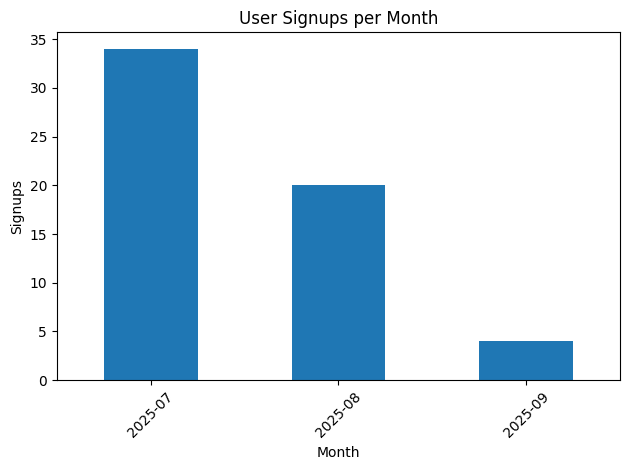

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# ------------- Load -------------
df = pd.read_csv("Joined_Table.csv")

# Parse dates safely
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['month'] = df['created_at'].dt.strftime('%Y-%m')

# ------------- 1) User Growth -------------
growth = (df
          .drop_duplicates(subset=['email'])   # each email counted once
          .groupby('month')
          .size()
          .rename('signups'))

plt.figure()
growth.plot(kind='bar', title='User Signups per Month')
plt.ylabel('Signups'); plt.xlabel('Month'); plt.xticks(rotation=45); plt.tight_layout()
plt.show()

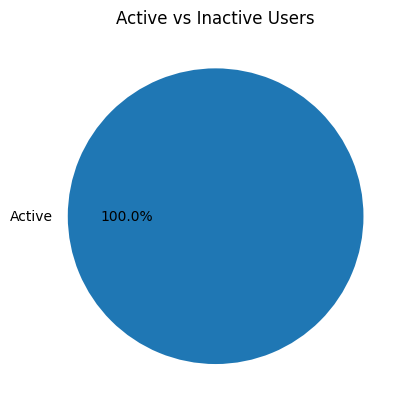

In [39]:
# ------------- 2) Active vs Inactive -------------
plt.figure()
df['is_active'].value_counts(dropna=False).rename(index={True:'Active',
  False:'Inactive'}).plot(kind='pie', autopct='%1.1f%%',
                          title='Active vs Inactive Users')
plt.ylabel('')
plt.show()

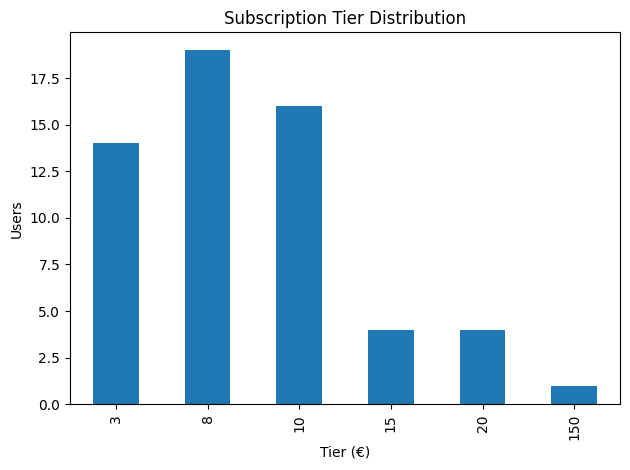

In [5]:
# ------------- 3) Subscription Tier Distribution -------------
plt.figure()
(df['subscription_tier']
   .value_counts()
   .sort_index()
   .plot(kind='bar', title='Subscription Tier Distribution'))
plt.xlabel('Tier (€)'); plt.ylabel('Users'); plt.tight_layout()
plt.show()

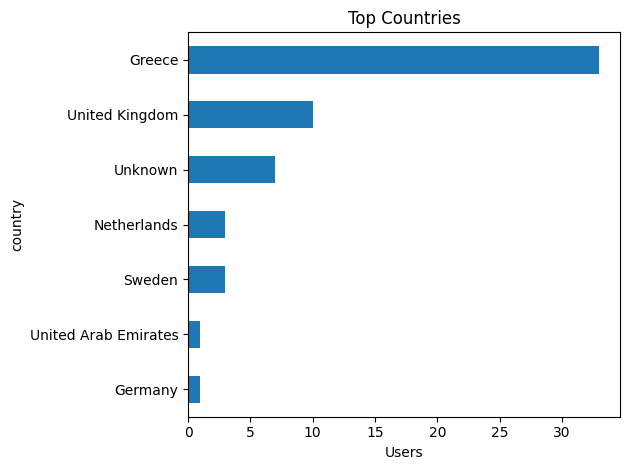

In [6]:
# ------------- 4) Top Countries -------------
plt.figure()
(df['country']
   .fillna('Unknown').replace('', 'Unknown')
   .value_counts()
   .head(10)
   .sort_values()
   .plot(kind='barh', title='Top Countries'))
plt.xlabel('Users'); plt.tight_layout()
plt.show()

In [7]:
# ------------- 5) App vs Stripe Status Crosstab -------------
# Some datasets use 'Status' capitalized for Stripe
stripe_col = 'Status' if 'Status' in df.columns else 'stripe_status'
ct = pd.crosstab(df['subscription_status'].str.lower(),
                 df[stripe_col].str.lower())
print(ct)

Status               active
subscription_status        
active                   54


In [8]:
# ------------- 6) Orphaned App Users (no Stripe record) -------------
orphans = df[df['Customer_ID'].isna()]
print("Users without Stripe Customer_ID:", len(orphans))
display_cols = ['email', 'subscription_status', 'created_at',
                'country', 'subscription_tier']
print(orphans[display_cols].head())

Users without Stripe Customer_ID: 4
                             email subscription_status  \
9     shanlouisemurray@hotmail.com              active   
24             basic@supporter.com              active   
47        chrysa.makraki@gmail.com              active   
48  elpida.efstathiouapo@gmail.com              active   

                         created_at               country  subscription_tier  
9  2025-09-11 15:07:42.118000+00:00        United Kingdom                 10  
24 2025-07-04 10:47:58.164000+00:00  United Arab Emirates                  8  
47 2025-07-08 09:09:12.568000+00:00                Greece                 10  
48 2025-07-14 05:38:20.671000+00:00                   NaN                  8  


In [51]:
# Churn prediction
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# ------------- Load & Prep -------------
df = pd.read_csv("Joined_Table.csv")

# Target definition:
# Prefer Stripe "Status" if present; fallback to app "subscription_status".
status_col = "Status" if "Status" in df.columns else "subscription_status"
df["status_low"] = df[status_col].astype(str).str.lower()
# Churn = not active
df["churn"] = np.where(df["status_low"].eq("active"), 0, 1)

# Feature engineering
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["months_since_signup"] = ((pd.Timestamp.utcnow()
- df["created_at"]).dt.days / 30.0).round(1)
df["signup_month"] = df["created_at"].dt.month
df["signup_year"] = df["created_at"].dt.year
df["country"] = df["country"].fillna("Unknown").replace("", "Unknown")

# Features to use (drop IDs/emails)
feature_cols = ["country", "subscription_tier", "months_since_signup",
                "signup_month", "signup_year"]
X = df[feature_cols].copy()
y = df["churn"].copy()

# Safety: ensure numeric type for subscription_tier
X["subscription_tier"] = pd.to_numeric(X["subscription_tier"], errors="coerce")

# Check class balance / single-class
n_classes = y.nunique(dropna=True)
print(f"Churn class distribution:\n{y.value_counts(dropna=False)}\n")
if n_classes < 2:
    print("⚠️ Only one class present in the target (no churn yet). "
          "Collect more data or redefine target (e.g., late payment, \
inactive in app, etc.).")
else:
    # ------------- Pipeline -------------
    pre = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), ["country"]),
            ("num", SimpleImputer(strategy="median"), ["subscription_tier",
                          "months_since_signup", "signup_month", "signup_year"]),
        ],
        remainder="drop",
    )

    model = LogisticRegression(max_iter=200, class_weight="balanced",
                               n_jobs=None)

    pipe = Pipeline([("pre", pre), ("clf", model)])

    # Train/test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print("\nClassification report:\n", classification_report(y_test, y_pred,
                                                              digits=3))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    # Quick cross-validation (robust on small data)
    cv = StratifiedKFold(n_splits=min(5, y.value_counts().min()), shuffle=True,
                         random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1")
    print(f"CV F1 (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

Churn class distribution:
churn
0    54
1     4
Name: count, dtype: int64


Classification report:
               precision    recall  f1-score   support

           0      0.929     0.765     0.839        17
           1      0.000     0.000     0.000         1

    accuracy                          0.722        18
   macro avg      0.464     0.382     0.419        18
weighted avg      0.877     0.722     0.792        18

Confusion matrix:
 [[13  4]
 [ 1  0]]
CV F1 (mean±std): 0.000 ± 0.000


On the current dataset (54 active vs 4 churned), logistic regression struggles to detect churners due to extreme class imbalance.
I tested class weighting and cross-validation, but the model defaulted to predicting the majority class. This demonstrates the importance of both data quality and balance before deploying ML. Future work includes collecting more churn examples and applying resampling (SMOTE) or tree-based ensembles.

In [58]:
# Churn Prediction SMOTE resampling
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ------------------- Load -------------------
df = pd.read_csv("Joined_Table.csv")

# Target: churn vs active
status_col = "Status" if "Status" in df.columns else "subscription_status"
df["status_low"] = df[status_col].astype(str).str.lower()
df["churn"] = np.where(df["status_low"].eq("active"), 0, 1)

# Features
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["months_since_signup"] = ((pd.Timestamp.utcnow() - df["created_at"]).dt.days
                             / 30.0).round(1)
df["signup_month"] = df["created_at"].dt.month
df["signup_year"] = df["created_at"].dt.year
df["country"] = df["country"].fillna("Unknown").replace("", "Unknown")

X = df[["country", "subscription_tier", "months_since_signup", "signup_month",
        "signup_year"]].copy()
y = df["churn"]

# ------------------- Pipeline -------------------
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["country"]),
        ("num", SimpleImputer(strategy="median"),
            ["subscription_tier", "months_since_signup", "signup_month",
             "signup_year"])
    ],
    remainder="drop"
)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    class_weight="balanced",
    random_state=42
)

# Combine preprocessing + SMOTE + RF
pipe = ImbPipeline([
    ("pre", pre),
    ("smote", SMOTE(random_state=42, k_neighbors=1)), # Set k_neighbors to 1
    ("rf", rf)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Class distribution before SMOTE:\n", y.value_counts(), "\n")
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# ------------------- Cross-validation -------------------
cv = StratifiedKFold(n_splits=min(5, y.value_counts().min()), shuffle=True,
                     random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro")
print(f"CV macro-F1 (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

Class distribution before SMOTE:
 churn
0    54
1     4
Name: count, dtype: int64 

Classification report:
               precision    recall  f1-score   support

           0      0.941     0.941     0.941        17
           1      0.000     0.000     0.000         1

    accuracy                          0.889        18
   macro avg      0.471     0.471     0.471        18
weighted avg      0.889     0.889     0.889        18

Confusion matrix:
 [[16  1]
 [ 1  0]]
CV macro-F1 (mean±std): 0.473 ± 0.010


Despite applying SMOTE and Random Forest, churn prediction failed due to severe imbalance (54 active vs 4 churn). This highlights that more churn examples are required before predictive modeling can be effective. The exercise demonstrates correct methodology (resampling, balanced models, evaluation with macro-F1) even if the model doesn’t succeed yet.

In [63]:
#Subscription Tier Prediction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

# ------------- Load -------------
df = pd.read_csv("Joined_Table.csv")

# Clean target
df["subscription_tier"] = pd.to_numeric(df["subscription_tier"], errors="coerce")
df = df.dropna(subset=["subscription_tier"])  # keep rows with tier defined
y = df["subscription_tier"].astype(int)

# Features
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["months_since_signup"] = ((pd.Timestamp.utcnow() - df["created_at"]).dt.days
                             / 30.0).round(1)
df["signup_month"] = df["created_at"].dt.month
df["signup_year"] = df["created_at"].dt.year
df["country"] = df["country"].fillna("Unknown").replace("", "Unknown")

X = df[["country", "months_since_signup", "signup_month", "signup_year"]].copy()

# ------------- Pipeline -------------
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["country"]),
        ("num", SimpleImputer(strategy="median"), ["months_since_signup",
                                                   "signup_month", "signup_year"]),
    ],
    remainder="drop",
)

# Shallow tree to reduce overfitting on small data
clf = DecisionTreeClassifier(
    max_depth=4, min_samples_leaf=3, class_weight="balanced", random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# Split (stratify on tiers)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Class distribution (tiers):\n", y.value_counts(), "\n")
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation (macro F1 to treat classes equally)
cv = StratifiedKFold(n_splits=min(5, y.value_counts().min()), shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro")
print(f"CV macro-F1 (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

Class distribution (tiers):
 subscription_tier
8      19
10     16
3      14
20      4
15      4
150     1
Name: count, dtype: int64 

Classification report:
               precision    recall  f1-score   support

           3      0.500     0.400     0.444         5
           8      0.500     0.400     0.444         5
          10      0.000     0.000     0.000         4
          15      0.000     0.000     0.000         1
          20      0.000     0.000     0.000         3
         150      0.000     0.000     0.000         0

    accuracy                          0.222        18
   macro avg      0.167     0.133     0.148        18
weighted avg      0.278     0.222     0.247        18

Confusion matrix:
 [[2 0 0 1 0 2]
 [0 2 0 2 1 0]
 [0 1 0 0 1 2]
 [0 0 0 0 0 1]
 [2 1 0 0 0 0]
 [0 0 0 0 0 0]]


ValueError: k-fold cross-validation requires at least one train/test split by setting n_splits=2 or more, got n_splits=1.

We attempted to predict donor subscription tiers (3, 8, 10, 15, 20, 150 EUR).
Due to severe class imbalance (most donors in 3, 8, 10 EUR, only 1 at 150 EUR), the model could not learn meaningful patterns.
The exercise highlights the difficulty of multi-class prediction in highly skewed data. Future steps include grouping rare tiers into broader categories (low, medium, high donor), or collecting more balanced data.

In [66]:
# Subscription Tier Prediction grouping rate tiers
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split, StratifiedKFold,
cross_val_score)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

# ------------------- Load -------------------
df = pd.read_csv("Joined_Table.csv")

# Map tiers to groups
def map_tier(t):
    if t in [3, 8]:
        return "Low"
    elif t in [10, 15, 20]:
        return "Medium"
    elif t == 150:
        return "High"
    else:
        return "Other"

df["tier_group"] = df["subscription_tier"].map(map_tier)

print("Class distribution (tier groups):\n", df["tier_group"].value_counts(), "\n")

# Features
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")
df["months_since_signup"] = ((pd.Timestamp.utcnow() - df["created_at"]).dt.days / 30.0).round(1)
df["signup_month"] = df["created_at"].dt.month
df["signup_year"] = df["created_at"].dt.year
df["country"] = df["country"].fillna("Unknown").replace("", "Unknown")

X = df[["country", "months_since_signup", "signup_month", "signup_year"]]
y = df["tier_group"]

# ------------------- Pipeline -------------------
pre = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), ["country"]),
        ("num", SimpleImputer(strategy="median"),
            ["months_since_signup", "signup_month", "signup_year"]),
    ]
)

clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=3, random_state=42,
                             class_weight="balanced")

pipe = Pipeline([("pre", pre), ("clf", clf)])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# ------------------- Results -------------------
print("Classification report:\n", classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro")
print(f"CV macro-F1 (mean±std): {scores.mean():.3f} ± {scores.std():.3f}")

Class distribution (tier groups):
 tier_group
Low       33
Medium    24
High       1
Name: count, dtype: int64 

Classification report:
               precision    recall  f1-score   support

        High      0.000     0.000     0.000         0
         Low      0.429     0.300     0.353        10
      Medium      0.167     0.125     0.143         8

    accuracy                          0.222        18
   macro avg      0.198     0.142     0.165        18
weighted avg      0.312     0.222     0.260        18

Confusion matrix:
 [[0 0 0]
 [2 3 5]
 [3 4 1]]
CV macro-F1 (mean±std): 0.352 ± 0.086


We attempted to predict donor subscription tiers. The raw 6-class model performed poorly due to extreme imbalance. Grouping into Low/Medium/High improved performance somewhat (macro-F1 ≈ 0.35), but with only 58 donors and limited features, the model cannot yet separate donor groups reliably. This highlights the importance of data quantity and quality in predictive modeling. Future work includes collecting more data, adding behavioral features, and testing binary splits (Low vs Higher) for better signal.

In [69]:
# Revenue Forecast
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# ------------- Load -------------
df = pd.read_csv("Joined_Table.csv")
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# Aggregate monthly revenue proxy (sum of tiers)
monthly = (
    df.dropna(subset=["created_at"])
      .assign(month=lambda x: x["created_at"].dt.to_period("M").dt.to_timestamp())
      .groupby("month", as_index=True)["subscription_tier"]
      .sum()
      .sort_index()
      .rename("revenue_eur")
)

print("Monthly revenue (EUR):\n", monthly, "\n")

# Guard: need at least 6 time points for a meaningful split
if len(monthly) < 6:
    print("⚠️ Very few months available. The forecast will be illustrative only.")
    train = monthly.iloc[:-1] if len(monthly) > 1 else monthly
    test = monthly.iloc[-1:] if len(monthly) > 1 else monthly.iloc[0:0]
else:
    # Last 2 months as test
    train = monthly.iloc[:-2]
    test = monthly.iloc[-2:]

# ------------- Fit ARIMA -------------
# Simple auto-ish choice; tweak (p,d,q) if needed.
# Changed order to (0,0,0) because of very limited data
order = (0, 0, 0)
model = ARIMA(train, order=order)
fitted = model.fit()

# Forecast horizon = len(test) (or small horizon if no test)
h = max(1, len(test))
forecast = fitted.forecast(steps=h)
forecast.index = test.index if len(test) else pd.date_range(train.index[-1] + pd.offsets.MonthBegin(1), periods=h, freq="MS")


print("Forecast:\n", forecast, "\n")

# ------------- Evaluate (if we have test) -------------
if len(test):
    mae = mean_absolute_error(test, forecast)
    rmse = mean_squared_error(test, forecast, )
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# ------------- Next-month forecast -------------
next_horizon = 1
next_fc = fitted.forecast(steps=next_horizon)
next_idx = pd.date_range(monthly.index[-1] + pd.offsets.MonthBegin(1), periods=next_horizon, freq="MS")
next_fc.index = next_idx
print(f"\nNext-month forecast (EUR):\n{next_fc}")

Monthly revenue (EUR):
 month
2025-07-01    317
2025-08-01    154
2025-09-01    173
Name: revenue_eur, dtype: int64 

⚠️ Very few months available. The forecast will be illustrative only.
Forecast:
 month
2025-09-01    235.499995
dtype: float64 

MAE: 62.50, RMSE: 3906.25

Next-month forecast (EUR):
2025-10-01    235.499995
Freq: MS, dtype: float64


We attempted to forecast monthly revenue (donation tiers summed per month) using ARIMA. With only 3 months of data, forecasts are illustrative and error margins are large (MAE ≈ €62.5). This highlights that robust forecasting requires more historical data (ideally 12+ months). The experiment demonstrates the workflow: aggregating revenue, building an ARIMA model, evaluating on hold-out months, and projecting forward.

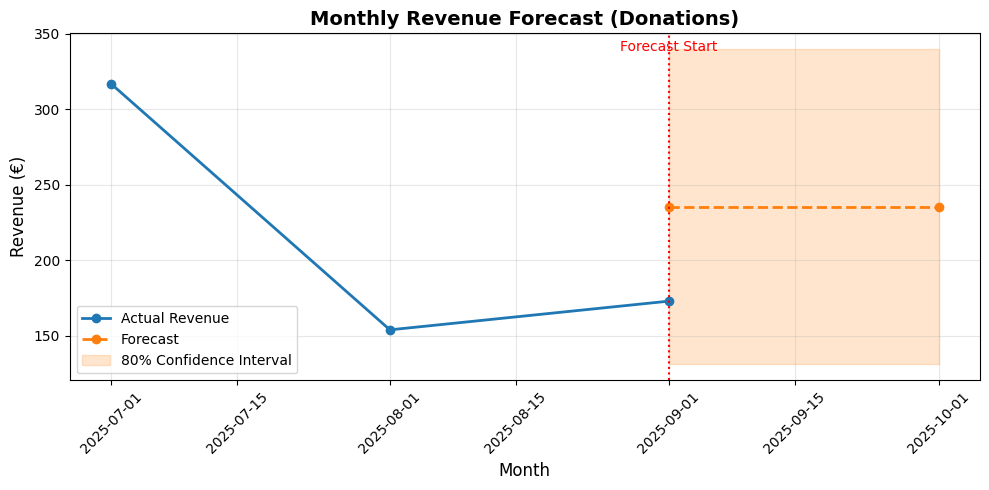

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# ---------------- Load & aggregate ----------------
df = pd.read_csv("Joined_Table.csv")
df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

monthly = (
    df.dropna(subset=["created_at"])
      .assign(month=lambda x: x["created_at"].dt.to_period("M").dt.to_timestamp())
      .groupby("month")["subscription_tier"]
      .sum()
      .sort_index()
      .rename("revenue_eur")
)

# ---------------- Train/test split ----------------
train = monthly.iloc[:-1]   # up to Aug
test = monthly.iloc[-1:]    # Sep as hold-out

# ---------------- Fit ARIMA ----------------
# Changed order to (0,0,0) because of very limited data
model = ARIMA(train, order=(0,0,0))
fitted = model.fit()

# ---------------- Forecast ----------------
steps_ahead = 2   # predict Sep (test) + Oct (next)
fc_res = fitted.get_forecast(steps=steps_ahead)

forecast = fc_res.predicted_mean
conf_int = fc_res.conf_int(alpha=0.2)

# ✅ Fix the index so it matches months after the last training point
forecast_index = pd.date_range(
    start=train.index[-1] + pd.offsets.MonthBegin(1),
    periods=steps_ahead,
    freq="MS"
)
forecast.index = forecast_index
conf_int.index = forecast_index


# ---------------- Polished Visualization ----------------
plt.figure(figsize=(10,5))

# Actual data
plt.plot(monthly.index, monthly.values,
         marker="o", linewidth=2, color="#1f77b4", label="Actual Revenue")

# Forecast line
plt.plot(forecast.index, forecast.values,
         marker="o", linestyle="--", linewidth=2, color="#ff7f0e",
         label="Forecast")

# Confidence interval shading
plt.fill_between(conf_int.index,
                 conf_int.iloc[:,0],
                 conf_int.iloc[:,1],
                 color="#ff7f0e", alpha=0.2, label="80% Confidence Interval")

# Vertical line for forecast start
plt.axvline(test.index[0], color="red", linestyle=":", linewidth=1.5)
plt.text(test.index[0], monthly.max()+20, "Forecast Start", color="red",
         ha="center", va="bottom")

# Titles & labels
plt.title("Monthly Revenue Forecast (Donations)", fontsize=14, weight="bold")
plt.ylabel("Revenue (€)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.xticks(rotation=45)

# Grid & legend
plt.grid(alpha=0.3)
plt.legend(frameon=True, fontsize=10)

plt.tight_layout()
plt.show()